In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import seaborn as sns
import sqlite3
import sys


from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sqlalchemy import create_engine


In [2]:
file_path = 'C:/path/spotify_top_songs_audio_features.csv'
df = pd.read_csv(file_path)
df = pd.DataFrame(df)
#print(df)

In [3]:
#Extract the metadata of each column's variable types
data_types = df.dtypes
#print(data_types)
#print(df.columns)

In [4]:
#Determine the maximal number of individual artists in the artists section 
artist_name_comma_count = df['artist_names'].str.count(',')
max_comma_count = artist_name_comma_count.max()
max_artist_count = max_comma_count + 1
print("The maximal number of artists of a single entry is :", (max_artist_count))

The maximal number of artists of a single entry is : 11


In [5]:
#Separate the artist_names into the corresponding number of max count of artists ina single statistics entries
new_columns = []
new_columns = df['artist_names'].str.split(',', expand=True)
new_columns.columns = ['artist'+str(i+1) for i in range (max_comma_count+1)]

#Set the new_columns into dataframe
new_columns = pd.DataFrame(new_columns)
#print(new_columns)
df = pd.DataFrame(df)
print(df)

                          id                         artist_names  \
0     000xQL6tZNLJzIrtIgxqSl                  ZAYN, PARTYNEXTDOOR   
1     003eoIwxETJujVWmNFMoZy                         Alessia Cara   
2     003vvx7Niy0yvhvHt4a68B                          The Killers   
3     00B7TZ0Xawar6NZ00JFomN           Cardi B, Chance the Rapper   
4     00Blm7zeNqgYLPtW6zg8cj              Post Malone, The Weeknd   
...                      ...                                  ...   
6508  7zgqtptZvhf8GEmdsM2vp2                         Taylor Swift   
6509  7zjEyeBsaw9gV0jofJLfOM  Young Thug, A$AP Rocky, Post Malone   
6510  7zl7kehxesNEo2pYkKXTSe          Eminem, Jack Harlow, Cordae   
6511  7zvfDihYiJ8RQ1nRcpKBF5          Kendrick Lamar, Tanna Leone   
6512  7zxRMhXxJMQCeDDg0rKAVo                      NAV, The Weeknd   

                                       track_name  \
0            Still Got Time (feat. PARTYNEXTDOOR)   
1                                   Growing Pains   
2           

In [6]:
#Check if artist_name 1-11 columns have any all-null columns
is_column_null = new_columns.isnull().all()
#print(is_column_null)

In [7]:
#Create an artist roster by stacking non-null columns of the new_columns matrix. The result will contains duplicates
artist_roster = []
artist_roster = new_columns.stack().dropna().tolist()

#artist_count_dup = len(artist_roster)
#print("Artist counts with duplicates:",artist_count_dup)

#Dropping duplicates and artist roster length report 
artist_roster = list(set(artist_roster))
artist_count_non_dup = len(artist_roster)
print("Artist counts without duplicates:",artist_count_non_dup)

#50 samples of the non-duplicate artist roster
print("50 non-duplicate artist roster sample:",artist_roster[:50])

Artist counts without duplicates: 2552
50 non-duplicate artist roster sample: ['Sam Hunt', 'Lil Mosey', ' Mc Lele JP', 'Colde', ' WATT', ' Desiigner', ' 13 Organisé', 'Alec Benjamin', ' Lil Wayne', 'LiL CaKe', 'DaBaby', ' Sky Rompiendo', 'Gabry Ponte', ' Super Subu', ' Knox Fortune', ' Lil Dicky', ' Skylar Grey', '$NOT', ' Central Cee', ' Young Stoner Life', 'Bausa', 'Kali Uchis', 'Dimitri Vegas & Like Mike', ' Jasmine Thompson', ' A-Trak', ' bbno$', 'Laufey', 'Natasha Bedingfield', 'Hotel Ugly', 'BlocBoy JB', ' XXXTENTACION', ' Eladio Carrion', ' Tokischa', ' Sosa Geek', 'Dave', 'AUR', 'JNR CHOI', 'Matt Terry', 'SAIKO', 'Anirudh Ravichander', ' KEVVO', ' benny blanco', 'NOTD', 'Metro Boomin', ' Coi Leray', 'Jax Jones', 'Steve Lacy', 'Gotye', 'Eno', ' Pitbull']


In [8]:
#Creating a dataframe out of unique artist roster and add features to it.
reg_df = pd.DataFrame(artist_roster,columns = ['artist_roster'])

#Sorting artist roster with alphabetical order
reg_df = reg_df.sort_values(by = 'artist_roster')

#Create and assign unique artist id
uid = range(1, artist_count_non_dup+1)
reg_df['uid'] = uid
reg_columns = ['uid','artist_roster']
reg_df = reg_df[reg_columns]
print(reg_df)

       uid artist_roster
535      1          $NOT
1634     2      (G)I-DLE
289      3     070 Shake
6        4   13 Organisé
1170     5      2 Chainz
...    ...           ...
1340  2548        thasup
380   2549     twocolors
1602  2550        zzoilo
152   2551            ¥$
2097  2552    Ñengo Flow

[2552 rows x 2 columns]


In [36]:
#Print out artist roster column in a csv file for keyword traffic research
# Your target directory
directory = r'C:\Users\huang\Desktop\Files\Immigration\Job Search\DS Portfolio\Tableau'

# Check if the directory exists, and create it if it does not
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the full path for the CSV file
file_path = os.path.join(directory, 'artist_roster.csv')

# Save the artist_roster to a CSV file in the specified directory
reg_df[['artist_roster']].to_csv(file_path, index=False)

In [9]:
#Establish a list "float_column_names" for columns names if their data types are "float64" or "int64"
float_column_names = []

for column in df.columns:
    if df[column].dtypes == 'float64' or df[column].dtypes =='int64':
        float_column_names.append(column)
print(float_column_names)
    

['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'loudness', 'tempo', 'duration_ms', 'weeks_on_chart', 'streams']


<function matplotlib.pyplot.show(close=None, block=None)>

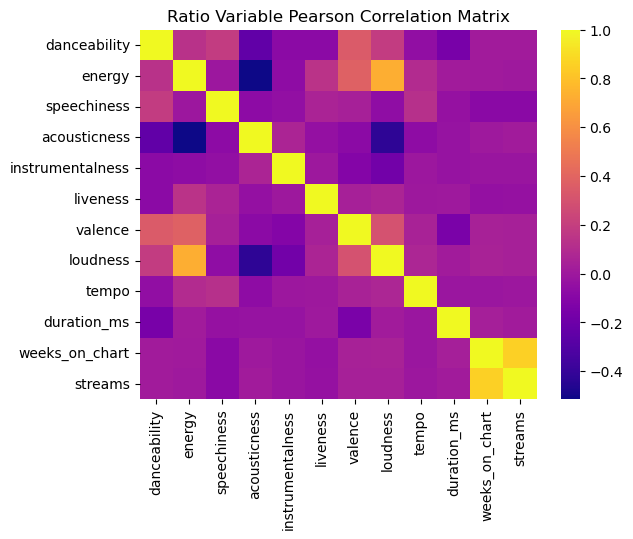

In [12]:
corr_df = df[float_column_names]
corr_matrix = corr_df.corr()
sns.heatmap(corr_matrix,cmap = 'plasma')
plt.title('Ratio Variable Pearson Correlation Matrix')
plt.show
#print(corr_matrix)

In [10]:
#Establish a filled dataframe for regression
for column in float_column_names:
    reg_df[column] = pd.NA
print(reg_df)

       uid artist_roster danceability energy speechiness acousticness  \
535      1          $NOT          NaN    NaN         NaN          NaN   
1634     2      (G)I-DLE          NaN    NaN         NaN          NaN   
289      3     070 Shake          NaN    NaN         NaN          NaN   
6        4   13 Organisé          NaN    NaN         NaN          NaN   
1170     5      2 Chainz          NaN    NaN         NaN          NaN   
...    ...           ...          ...    ...         ...          ...   
1340  2548        thasup          NaN    NaN         NaN          NaN   
380   2549     twocolors          NaN    NaN         NaN          NaN   
1602  2550        zzoilo          NaN    NaN         NaN          NaN   
152   2551            ¥$          NaN    NaN         NaN          NaN   
2097  2552    Ñengo Flow          NaN    NaN         NaN          NaN   

     instrumentalness liveness valence loudness tempo duration_ms  \
535               NaN      NaN     NaN      NaN   NaN 

In [18]:


for attribute in float_column_names:
    mean_attribute_list = []  # Reset the list for each attribute
    
    for indv_artist in reg_df['artist_roster']:
        # Escape special characters in the artist's name to prevent regex disruption
        escaped_indv_artist = re.escape(indv_artist)
        
        # Perform a wildcard search for the artist in 'df', then select the current attribute column
        artist_match = df['artist_names'].str.contains(f'.*{escaped_indv_artist}.*', regex=True, case=False)
        matched_attribute_values = df.loc[artist_match, attribute]
        
        # Calculate the mean attribute for the matched artist and append it to the list
        mean_attribute = matched_attribute_values.mean()
        mean_attribute_list.append(mean_attribute)
    
    # Assign the list of mean danceability values to a new column in 'reg_df'
    reg_df[attribute] = mean_attribute_list

In [25]:
#Visualize the dataset for regression 
print(reg_df)

       uid artist_roster  danceability    energy  speechiness  acousticness  \
535      1          $NOT      0.672000  0.717000     0.226000      0.103000   
1634     2      (G)I-DLE      0.634000  0.804333     0.054333      0.014123   
289      3     070 Shake      0.501250  0.763500     0.210250      0.107200   
6        4   13 Organisé      0.901000  0.939000     0.274000      0.117000   
1170     5      2 Chainz      0.731000  0.542429     0.293714      0.048734   
...    ...           ...           ...       ...          ...           ...   
1340  2548        thasup      0.686833  0.743000     0.172150      0.168900   
380   2549     twocolors      0.677000  0.766000     0.056800      0.021900   
1602  2550        zzoilo      0.748000  0.761000     0.102000      0.122000   
152   2551            ¥$      0.635143  0.647214     0.169186      0.181120   
2097  2552    Ñengo Flow      0.727400  0.783800     0.216580      0.136900   

      instrumentalness  liveness   valence  loudnes

In [13]:
# Scitkit-Learn for Regression
# Dependent variable
dependent = ['streams']
y = df[dependent]
# Independent variables, excluding 'streams' as a self-explanatory factor
independent = [column for column in float_column_names if column not in y.columns]
X = df[independent]
#X = X.drop('weeks_on_chart', axis = 1)

In [14]:
# Cutting dataframe for traning and testing of GB Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

chart_popularity_reg_numerical= GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=0)
chart_popularity_reg_numerical.fit(X_train, y_train)


C:\Users\huang\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(learning_rate=1.0, random_state=0)

In [15]:
# Making predictions
predictions = chart_popularity_reg_numerical.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 2.8480452729476824e+16
R-squared: 0.5495262915705044


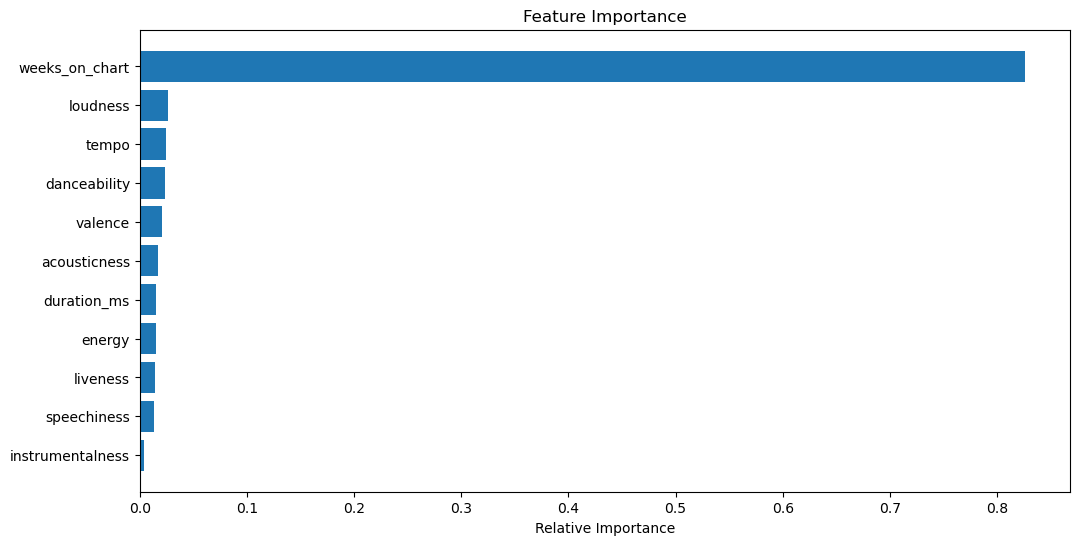

In [16]:
#Feature Importance 
feature_importance = chart_popularity_reg_numerical.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()